In [3]:
using WignerSymbols, PyPlot, LaTeXStrings, DelimitedFiles, LinearAlgebra
using PyCall
LineCollection = matplotlib.collections.LineCollection

PyObject <class 'matplotlib.collections.LineCollection'>

# Dysprosium polarizability using the lines of [Li et al.](https://iopscience.iop.org/article/10.1088/1361-6455/50/1/014005/meta?casa_token=fdHnA09HK5YAAAAA:udMr6w5uNeI5ymUbqNnQTZblKQiRSeYYoepYsFGMrxY2bt5KqtGu9WEa6M7q-kmo-hczrc5g)

In [4]:
const mₑ = 9.109E-31
const c = 2.997E8
const ħ = 1.05457E-34
const e = 1.6022E-19
const a₀ = 5.29177E-11
const ϵ₀ = 8.8542E-12
const au_pol = 1.65E-41
const Eh = ħ^2 / (mₑ * a₀^2)    # Hartree energy
const Ia = 0;                    # Nuclear spin

toω(λ) = 2*π*137 / λ   # in a.u.
toλ(ω) = 2*π*c/ω;

The reduced matrix element depends on the oscillator strength $A_{ik}$ through

$|\langle n'J' || \mathbf{d} || nJ \rangle |^2 = \frac{3\pi\epsilon_0\hbar c^3}{\omega_{ik}^3} (2J' + 1) A_{ik}.$

The oscillator strengths can be obtained through the [NIST database](https://physics.nist.gov/cgi-bin/ASD/lines_hold.pl?el=Dy) (click "Dy I," they're labeled $A_{ki}$ in that table).

Following the conventions of Le Kien and other literature, we absorb $\sqrt{2J+1}$ into the reduced matrix element.

In [5]:
linesdat = readdlm("J9_13496cm1_Spectre-Eexp.txt", Float64);

In [6]:
Jps = linesdat[:, 2]
Js = linesdat[:, 1]
Γs = linesdat[:, 5]
λs = 2*π * 137 ./ linesdat[:, 3]
redMatEls = sqrt.( linesdat[:, 4] );

Γ′s = c*Γs/a₀/137;
λ′s = λs*a₀*1e9
ω′s=2*pi*c*1e9 ./λ′s;

In [7]:
function α(K, J, ω)
    prefac = Complex(-1)^(K + J + 1) * sqrt(2*K + 1)
    terms = [Complex(-1)^Jp * wigner6j(1, K, 1, J, Jp, J) * redMatEl^2 * ( 1/(toω(λ) - ω - 1im * γ/2) + (-1)^K/(toω(λ) + ω + 1im * γ/2) ) for (Jp, redMatEl, λ, γ) ∈ zip(Jps, redMatEls, λs, Γs) ]
    s = sum(terms)
    return (prefac * s)
end

α (generic function with 1 method)

In [8]:
αs(ω) = 1/sqrt(3 * (2*Js[1] + 1) ) * α(0, Js[1], ω) 
αv(ω) = sqrt(2*Js[1] / ( (Js[1] + 1)*(2*Js[1] + 1) )) * α(1, Js[1], ω)
αt(ω) = -sqrt( 2*Js[1] * (2*Js[1] - 1) / ( 3*(Js[1] + 1) * (2*Js[1] + 1) * (2*Js[1] + 3) ) ) * α(2, Js[1], ω)

αt (generic function with 1 method)

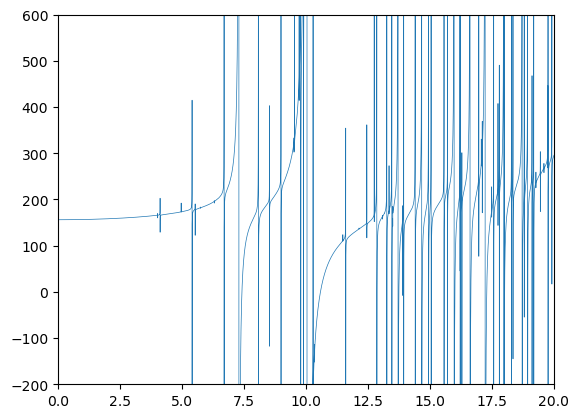

(0.0, 20.0)

In [13]:
fig, ax = plt.subplots()
λsp = [0:0.001:20;]*1e3  #in the unit of wavenumber

ax.plot(λsp/1e3, real.([αs(toω( (0.01/λ) / a₀)) for λ ∈ λsp]), label = "Us", lw = 0.5)
ax.set_ylim([-200, 600])
ax.set_xlim([0, 20])

In [14]:
real(αs(0)) # This gives 156, a little bit below 160 ,close to Maxence's figure.

156.12345414855778

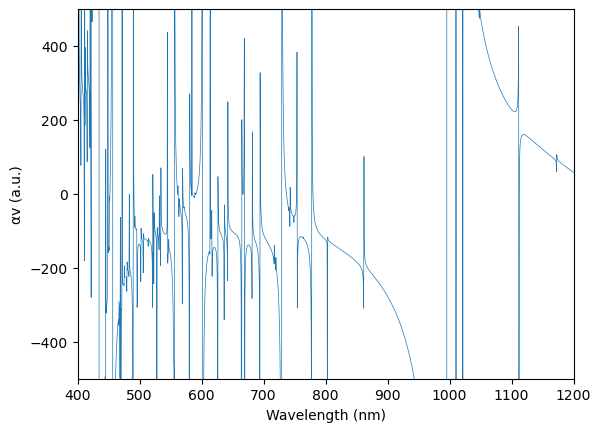

PyObject Text(24.0, 0.5, 'αv (a.u.)')

In [17]:
fig, ax = plt.subplots()

λsp = [400:0.5:1200;]*1e-9

ax.plot(1e9 .* λsp, real.([αv(toω(λ / a₀)) for λ ∈ λsp]), lw = 0.5, label = "Us - vector")
ax.set_ylim([-5e2, 5e2])
ax.set_xlim([400, 1200])

xlabel("Wavelength (nm)")
ylabel("αv (a.u.)")

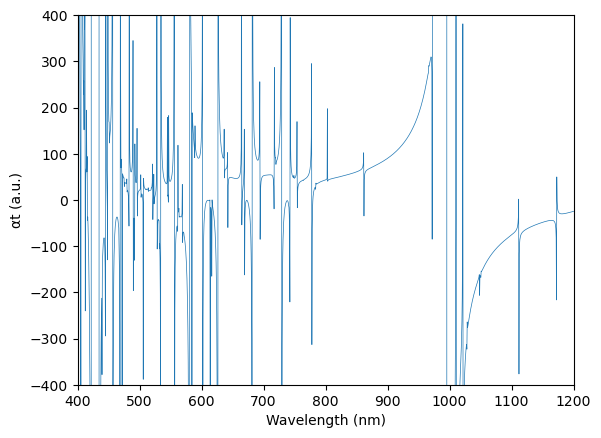

PyObject Text(24.0, 0.5, 'αt (a.u.)')

In [18]:
fig, ax = plt.subplots()
λsp = [400:0.5:1200;]*1e-9

tensor_pols = [αt(toω(λ / a₀)) for λ ∈ λsp]

ax.plot((λsp * 1e9), real.(tensor_pols), lw = 0.5, label = "Us - vector")
ax.set_ylim([-4e2, 4e2])
ax.set_xlim([400, 1200])

xlabel("Wavelength (nm)")
ylabel("αt (a.u.)")

In [9]:
function uu(K, q, pol)
    function sumterm(K, q, μ, μp, pol)
        # Check if CG is physical
        if μ - q + μp == 0
            Complex(-1)^(q + μp) * pol[μ + 2] * conj(pol[2 - μp]) * sqrt(2*K + 1)  * wigner3j(1, K, 1, μ, -q, μp)
        else
            0
        end
    end
    return sum([sumterm(K, q, μ, μp, pol) for μ ∈ (-1, 0, 1) for μp in (-1, 0, 1)])
end

function α_tot(ω, J, mJ, Jp, mJp, pol; Kmax = 2)
    if abs(mJ - mJp) > 2
        return 0.0
    else
        return real(sum([ α(K, J, ω) * uu(K, q, pol) * Complex(-1)^(J + Ia + K + q - mJ) *
            sqrt((2*J + 1) * (2*Jp + 1)) * wigner3j(J, K, Jp, mJ, q, -mJp) *
            wigner6j(J, K, Jp, J, Ia, J) for K ∈ [0:Kmax;] for q ∈ [-K:K;]]))
    end
end

function α_tot_precalc(αs, J, mJ, Jp, mJp, pol; Kmax = 2)
    # Same as above, but requires α(K, J, ω) to be precalculated, feed in as array [α(0, J, ω), ..., α(2, J, ω)]
    if abs(mJ - mJp) > 2
        return 0.0
    else
        return real(sum([ αs[K + 1] * uu(K, q, pol) * Complex(-1)^(J + Ia + K + q - mJ) *
            sqrt((2*J + 1) * (2*Jp + 1)) * wigner3j(J, K, Jp, mJ, q, -mJp) *
            wigner6j(J, K, Jp, J, Ia, J) for K ∈ [0:Kmax;] for q ∈ [-K:K;]]))
    end
end

α_tot_precalc (generic function with 1 method)

In [10]:
function normalized_polarization_eigenstates(ω, pol; Kmax = 2, offdiag = true, return_vecs = false)
    αmat = zeros(17, 17)
    αs = [α(K, 8, ω) for K ∈ 0:2]
    for (i, mJ) ∈ enumerate(-8:8)
        for (j, mJp) ∈ enumerate(mJ:8)
            αmat[i, i+j-1] = α_tot_precalc(αs, 8, mJ, 8, mJp, pol; Kmax = Kmax)
        end
    end
    if offdiag
        if return_vecs
            return eigen(Symmetric(αmat, :U))
        else
            return eigvals(Symmetric(αmat, :U))
        end
    else
        return diag(αmat)
    end
end

normalized_polarization_eigenstates (generic function with 1 method)

In [10]:
α_tot(toω(741e-9 / a₀), 8, 8, 8, 8, [0, 0, 1])

-241.52398011837133

In [11]:
λ₀ = λs[253] * a₀
# α_tot(toω(λ / a₀))

7.407704310604077e-7

In [12]:
mJ = 8
α_tot( toω(λ₀ / a₀) - 2*π*2.5e9 * ħ/Eh, 8, mJ, 8, mJ, [1, 0, 0] ) / α_tot( toω(λ₀ / a₀) - 2*π*5e9 * ħ/Eh, 8, mJ, 8, mJ, [0, 0, 1] )

2.5531052799579577

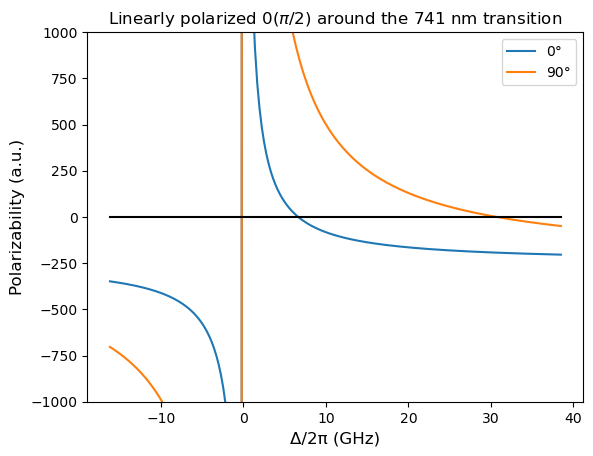

(-1000.0, 1000.0)

In [168]:
λrange = range(740.7e-9, 740.8e-9, length = 200)
λ₀ = 740.7704310604076e-9
fig, ax = plt.subplots()

plot1=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [real.(-αs(toω(λ / a₀))-αt(toω(λ/ a₀))) for λ ∈ λrange],label="0°")

plot2=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [real.(-αs(toω(λ / a₀))+0.5*αt(toω(λ/ a₀))) for λ ∈ λrange],label="90°")

plot3=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [0 for λ ∈ λrange],color="k")

ax.set_xlabel("Δ/2π (GHz)", fontsize = 12)
ax.set_ylabel("Polarizability (a.u.)", fontsize = 12)
ax.set_title(L"Linearly polarized $0(\pi/2)$ around the 741 nm transition")
handles1, labels1 = ax.get_legend_handles_labels()
ax.legend(handles1, labels1)

ax.set_ylim([-1000, 1000])


In [22]:
latwavelength = 532e-9

println(αs(toω(latwavelength / a₀)));

println(αv(toω(latwavelength/ a₀)));

println(αt(toω(latwavelength/ a₀)));

237.88561301253952 + 1.533206086212158e-5im
-4.949892926751366 + 1.510535267595845e-6im
-105.70979879350901 + 3.7359244876855504e-6im


In [193]:
αp(Kmax) = [α_tot(toω(latwavelength / a₀), 8, mJ, 8, mJ, [1, 0, 0], Kmax = Kmax) for mJ ∈ [-8:8;]]
αm(Kmax) = [α_tot(toω(latwavelength / a₀), 8, mJ, 8, mJ, [0, 0, 1], Kmax = Kmax) for mJ ∈ [-8:8;]];

In [196]:
function get_levels(σp_beam, σm_beam; Kmax = 2, offdiag = true, return_vecs = false)
    levels = zeros(length(σp_beam), 17)
    expsz = zeros(length(σp_beam), 17)
    for i ∈ 1:length(σp_beam)
        pol = [σp_beam[i], 0, σm_beam[i]]
        pol = pol/norm(pol)
        if return_vecs
            vals, vecs = normalized_polarization_eigenstates(toω(latwavelength / a₀), pol; Kmax = Kmax, offdiag = offdiag, return_vecs = return_vecs)  
            levels[i, :] = (σp_beam[i]^2 + σm_beam[i]^2) * vals
            expsz[i, :] = abs.(vecs.^2)' * [-8.:1.:8.;]
        else
            levels[i, :] = (σp_beam[i] + σm_beam[i]) * normalized_polarization_eigenstates(toω(latwavelength / a₀), pol; Kmax = Kmax, offdiag = offdiag, return_vecs = return_vecs)
        end
    end
    
    if return_vecs
        return levels, expsz
    else
        return levels
    end
end


get_levels (generic function with 1 method)

## Tweezer cartoon

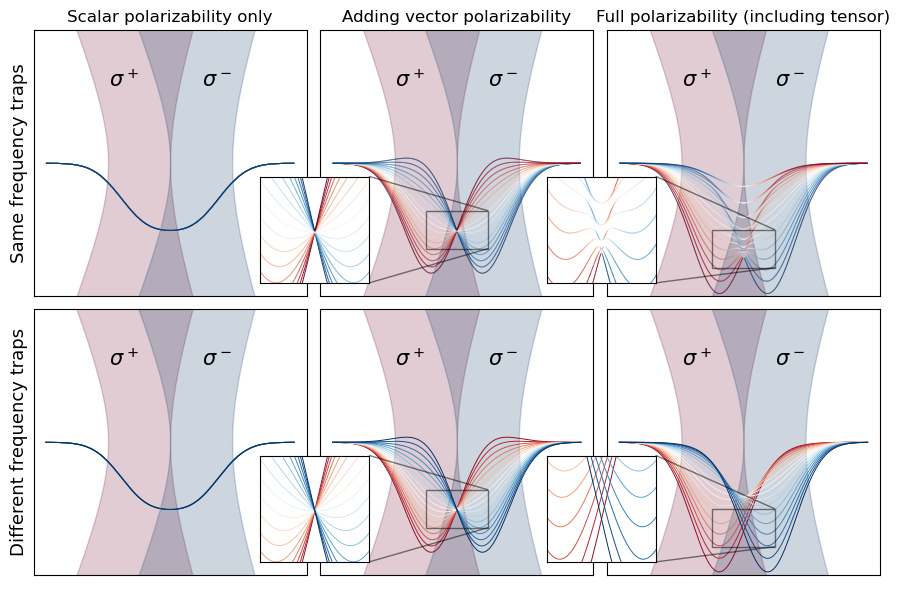

In [16]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6), sharex = true)
ax = vcat(permutedims(ax)...)
cmap = matplotlib.cm.get_cmap("RdBu");

axinss = [ax[i].inset_axes([-0.22, 0.05, 0.4, 0.4]) for i in [2, 3, 5, 6]]
axinss[1].set_ylim([-9000, -5000])
axinss[2].set_ylim([-11000, -7000])
axinss[3].set_ylim([-9000, -5000])
axinss[4].set_ylim([-11000, -7000])

for (i, axins) ∈ enumerate(axinss)
    axins.set_xlim([-1, 1])
    axins.set_yticks([])
    axins.set_xticks([])
end

xdum = range(-4, 4, length = 1000)
tweezer_sep = 1.0
σp_beam = exp.(-(xdum .- tweezer_sep).^2/(2)^2)
σm_beam = exp.(-(xdum .+ tweezer_sep).^2/(2)^2)

for (k, Kmax) ∈ enumerate([0:2;])
    potentials, szexp = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = true, return_vecs = true)
    for (i, p) ∈ enumerate(eachrow(potentials'))
        a = [xdum p]
        linecol = cat(a[1:(end-1), :], a[2:end, :], dims = 3)
        linecol = permutedims(linecol, [1, 3, 2])
        lc = LineCollection(linecol, colors = cmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
        ax[k].add_collection(lc)
        if k > 1
            lc = LineCollection(linecol, colors = cmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
            axinss[k-1].add_collection(lc)
        end
    end
end

for (k, Kmax) ∈ enumerate([0:2;])
    potentials = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = false)
    [ax[k + 3].plot(xdum, p, c = cmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]
    if k > 1
        [axinss[k + 1].plot(xdum, p, c = cmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]
    end
end

ydum = range(-15000, 15000, length = 200)
for i ∈ 1:length(ax)
    ax[i].fill_betweenx(ydum, -sqrt.(1 .+ (ydum/8000).^2) .- tweezer_sep, sqrt.(1 .+ (ydum/10000).^2) .- tweezer_sep, color = cmap(0), alpha = 0.2)
    ax[i].fill_betweenx(ydum, -sqrt.(1 .+ (ydum/8000).^2) .+ tweezer_sep, sqrt.(1 .+ (ydum/10000).^2) .+ tweezer_sep, color = cmap(255), alpha = 0.2)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].text(-(tweezer_sep+0.5), 8000, L"\sigma^+", horizontalalignment = "center", fontsize = 15)
    ax[i].text(tweezer_sep+0.5, 8000, L"\sigma^-", horizontalalignment = "center", fontsize = 15)
    ax[i].set_ylim([-14000, 14000])
end
    
ax[1].set_title("Scalar polarizability only")
ax[2].set_title("Adding vector polarizability")
ax[3].set_title("Full polarizability (including tensor)")

ax[1].set_ylabel("Same frequency traps", fontsize = 13)
ax[4].set_ylabel("Different frequency traps", fontsize = 13)

ax[2].indicate_inset_zoom(axinss[1], edgecolor = "black")
ax[3].indicate_inset_zoom(axinss[2], edgecolor = "black")
ax[5].indicate_inset_zoom(axinss[3], edgecolor = "black")
ax[6].indicate_inset_zoom(axinss[4], edgecolor = "black")

fig.tight_layout()
fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
# fig.savefig("tweezer_cartoon.png", dpi = 300)

## Lattice cartoon

Matplotlib settings:

In [19]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["mathtext.fontset"] = "stix";
rcParams["figure.dpi"] = 150;

Load custom colormap:

In [26]:
pushfirst!(PyVector(pyimport("sys")."path"), "")
ccmap = pyimport("newcmap")
pyimport("importlib")["reload"](ccmap)
mycmap = ccmap.custom_cmap();

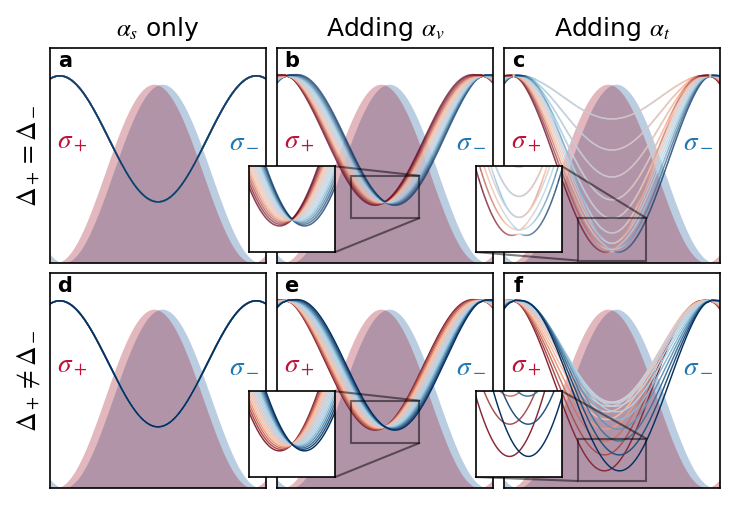

In [58]:
fig, ax = plt.subplots(2, 3, figsize = (5, 3.5), sharex = true)
ax = vcat(permutedims(ax)...)
cmap = matplotlib.cm.get_cmap("RdBu");

axinss = [ax[i].inset_axes([-0.13, 0.05, 0.4, 0.4]) for i in [2, 3, 5, 6]]

axinss[1].set_ylim([-16000, -11250])
axinss[2].set_ylim([-20750, -16000])
axinss[3].set_ylim([-16000, -11250])
axinss[4].set_ylim([-20250, -15500])

for (i, axins) ∈ enumerate(axinss)
    axins.set_xlim([-0.35, 0.35])
    axins.set_yticks([])
    axins.set_xticks([])
end

xdum = range(-1.1, 1.1, length = 1000) #20
σp_beam = cos.(π*xdum/2 .- π/6/8).^2
σm_beam = cos.(π*xdum/2 .+ π/6/8).^2

for (k, Kmax) ∈ enumerate([0:2;])
    potentials, szexp = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = true, return_vecs = true)
    potentials *= 1.9
    for (i, p) ∈ enumerate(eachrow(potentials'))
        a = [xdum p]
        linecol = cat(a[1:(end-1), :], a[2:end, :], dims = 3)
        linecol = permutedims(linecol, [1, 3, 2])
        lc = LineCollection(linecol, colors = mycmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
        ax[k].add_collection(lc)
        if k > 1
            lc = LineCollection(linecol, colors = mycmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
            axinss[k-1].add_collection(lc)
        end
    end
end

for (k, Kmax) ∈ enumerate([0:2;])
    potentials = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = false)
    potentials *= 1.9
    [ax[k + 3].plot(xdum, p, c = mycmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]
    if k > 1
        [axinss[k+1].plot(xdum, p, c = mycmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]
    end
end

ydum = range(-12000, 12000, length = 400)
letters = ["a", "b", "c", "d", "e", "f"]
for i ∈ 1:length(ax)
    ax[i].fill_between(xdum, -2.1e4, σp_beam*2e4 .- 2.1e4, color = cmap(235), alpha = 0.3, lw = 0) #cmap(235)
    ax[i].fill_between(xdum, -2.1e4, σm_beam*2e4 .- 2.1e4, color = cmap(20), alpha = 0.3, lw = 0) #cmap(20)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].text(-0.875, -8000, L"\sigma_+", horizontalalignment = "center", fontsize = 13, color = "#bf113a")
    ax[i].text(0.875, -8000, L"\sigma_-", horizontalalignment = "center", fontsize = 13, color = "C0")
    ax[i].set_ylim([-21000, 3000])
    ax[i].text(-0.95, 950, letters[i], horizontalalignment = "center", fontsize = 10, fontweight = "bold")
    ax[i].set_xlim([-1.1, 1.1])
end

    
ax[1].set_title(L"$\alpha_s$ only")
ax[2].set_title(L"Adding $\alpha_v$")
ax[3].set_title(L"Adding $\alpha_t$")

ax[1].set_ylabel(L"$\Delta_+ = \Delta_-$", fontsize = 13)
ax[4].set_ylabel(L"\Delta_+ \neq \Delta_-", fontsize = 13)

ax[2].indicate_inset_zoom(axinss[1], edgecolor = "black")
ax[3].indicate_inset_zoom(axinss[2], edgecolor = "black")
ax[5].indicate_inset_zoom(axinss[3], edgecolor = "black")
ax[6].indicate_inset_zoom(axinss[4], edgecolor = "black")

fig.tight_layout()
fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
# fig.savefig("lattice_cartoon.pdf", dpi = 300)
fig.savefig("lattice_cartoon_smaller_separation.pdf", dpi = 300)

## Export data

In [69]:
using DelimitedFiles

In [102]:
open("output/coupled_potentials_" * fname[1] * ".csv", write=true) do f
    write(f, join(string.([xdum;]), ","))
end
string([xdum;])

"[-3.0, -2.8461538461538463, -2.6923076923076925, -2.5384615384615383, -2.3846153846153846, -2.230769230769231, -2.076923076923077, -1.9230769230769231, -1.7692307692307692, -1.6153846153846154, -1.4615384615384615, -1.3076923076923077, -1.1538461538461537, -1.0, -0.8461538461538461, -0.6923076923076923, -0.5384615384615384, -0.38461538461538464, -0.23076923076923078, -0.07692307692307693, 0.07692307692307693, 0.23076923076923078, 0.38461538461538464, 0.5384615384615384, 0.6923076923076923, 0.8461538461538461, 1.0, 1.1538461538461537, 1.3076923076923077, 1.4615384615384615, 1.6153846153846154, 1.7692307692307692, 1.9230769230769231, 2.076923076923077, 2.230769230769231, 2.3846153846153846, 2.5384615384615383, 2.6923076923076925, 2.8461538461538463, 3.0]"

In [106]:
cmap = matplotlib.cm.get_cmap("RdBu");

xdum = range(-3.0, 3.0, length = 400) #20
σp_beam = cos.(π*xdum/2 .- π/6/8).^2
σm_beam = cos.(π*xdum/2 .+ π/6/8).^2

fname = ["scalar", "vector", "tensor"]

for (k, Kmax) ∈ enumerate([0:2;])
    potentials, szexp = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = true, return_vecs = true)
    potentials *= 1.9
    open("output/coupled_potentials_" * fname[k] * ".csv", write=true) do f
        write(f, join(string.([xdum;]), ","), "\n")
        writedlm(f, transpose(potentials), ",")
    end
    open("output/coupled_sz_" * fname[k] * ".csv", write=true) do f
        write(f, join(string.([xdum;]), ","), "\n")
        writedlm(f, transpose(szexp), ",")
    end
    for (i, p) ∈ enumerate(eachrow(potentials'))
        a = [xdum p]
        linecol = cat(a[1:(end-1), :], a[2:end, :], dims = 3)
        linecol = permutedims(linecol, [1, 3, 2])
        lc = LineCollection(linecol, colors = mycmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
        if k > 1
            lc = LineCollection(linecol, colors = mycmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
        end
    end
end

for (k, Kmax) ∈ enumerate([0:2;])
    potentials = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = false)
    potentials *= 1.9
    open("output/uncoupled_potentials_" * fname[k] * ".csv", write=true) do f
        write(f, join(string.([xdum;]), ","), "\n")
        writedlm(f, transpose(potentials), ",")
    end
end

# ydum = range(-12000, 12000, length = 400)
# letters = ["a", "b", "c", "d", "e", "f"]
# for i ∈ 1:length(ax)
#     ax[i].fill_between(xdum, -2.1e4, σp_beam*2e4 .- 2.1e4, color = cmap(235), alpha = 0.3, lw = 0) #cmap(235)
#     ax[i].fill_between(xdum, -2.1e4, σm_beam*2e4 .- 2.1e4, color = cmap(20), alpha = 0.3, lw = 0) #cmap(20)
#     ax[i].set_yticks([])
#     ax[i].set_xticks([])
#     ax[i].text(-0.875, -8000, L"\sigma_+", horizontalalignment = "center", fontsize = 13, color = "#bf113a")
#     ax[i].text(0.875, -8000, L"\sigma_-", horizontalalignment = "center", fontsize = 13, color = "C0")
#     ax[i].set_ylim([-21000, 3000])
#     ax[i].text(-0.95, 950, letters[i], horizontalalignment = "center", fontsize = 10, fontweight = "bold")
#     ax[i].set_xlim([-1.1, 1.1])
# end

In [12]:
pol = [1, 0, 0]
pol = pol/norm(pol)
vals=normalized_polarization_eigenstates(toω(latwavelength/a₀), pol; Kmax = 2, offdiag = true, return_vecs = false)

17-element Vector{Float64}:
 -12072.68071775233
 -10758.74343011401
  -9522.04957137562
  -8362.59914153716
  -7280.392140598629
  -6275.428568560027
  -5347.708425421354
  -4497.23171118261
  -3723.9984258437944
  -3028.0085694049076
  -2409.2621418659505
  -1867.7591432269223
  -1403.4995734878232
  -1016.4834326486529
   -706.7107207094115
   -474.1814376701002
   -318.89558353071675